# **Full Code**

### **Initial Analysis**

In [1]:
!pip install opencv-python-headless

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir = '/content/drive/MyDrive/Need/Up/Melanie/Dataset'

AiArt_dir = os.path.join(base_dir, 'AiArtData')
RealArt_dir = os.path.join(base_dir, 'RealArt')

print('total training Ai images:', len(os.listdir(AiArt_dir)))
print('total training Real images:', len(os.listdir(RealArt_dir)))


total training Ai images: 539
total training Real images: 436


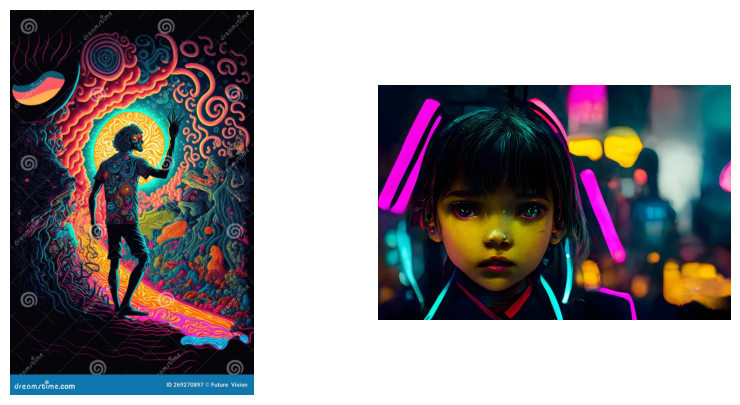

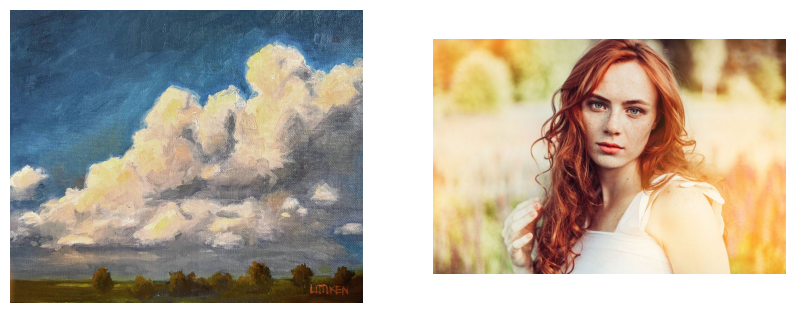

In [5]:
def display_images(image_paths):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

ai_art_files = os.listdir(AiArt_dir)[:2]
real_art_files = os.listdir(RealArt_dir)[:2]

display_images([os.path.join(AiArt_dir, fname) for fname in ai_art_files])
display_images([os.path.join(RealArt_dir, fname) for fname in real_art_files])

In [6]:
ai_art_count = len(os.listdir(AiArt_dir))
real_art_count = len(os.listdir(RealArt_dir))

print(f'Total training AiArt images: {ai_art_count}')
print(f'Total training RealArt images: {real_art_count}')

# Checking for imbalance
if abs(ai_art_count - real_art_count) / max(ai_art_count, real_art_count) > 0.2:
    print("Dataset is significantly imbalanced.")
else:
    print("Dataset is relatively balanced.")


Total training AiArt images: 539
Total training RealArt images: 436
Dataset is relatively balanced.


In [7]:
# Example for analyzing image dimensions
from PIL import Image

first_ai_image = Image.open(os.path.join(AiArt_dir, ai_art_files[0]))
print(f"First AiArt image dimensions: {first_ai_image.size}")

first_real_image = Image.open(os.path.join(RealArt_dir, real_art_files[0]))
print(f"First RealArt image dimensions: {first_real_image.size}")


First AiArt image dimensions: (1067, 1690)
First RealArt image dimensions: (1068, 889)


In [8]:
# Data Augmentation and Data Splitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(255, 255),
    class_mode='categorical',
    batch_size=64,
    subset='training'  # Specify this is training data
)

# Validation Data Generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(255, 255),
    class_mode='categorical',
    batch_size=16,
    subset='validation'  # Specify this is validation data
)


Found 728 images belonging to 2 classes.
Found 242 images belonging to 2 classes.


### **CNN**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)


In [20]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/100
12/12 [==============================] - 160s 13s/step - loss: 0.6583 - accuracy: 0.6085 - val_loss: 0.6152 - val_accuracy: 0.6446
Epoch 2/100
12/12 [==============================] - 158s 13s/step - loss: 0.6646 - accuracy: 0.6044 - val_loss: 0.6452 - val_accuracy: 0.6818
Epoch 3/100
12/12 [==============================] - 160s 13s/step - loss: 0.6526 - accuracy: 0.6374 - val_loss: 0.6048 - val_accuracy: 0.6612
Epoch 4/100
12/12 [==============================] - 159s 13s/step - loss: 0.6377 - accuracy: 0.6387 - val_loss: 0.5989 - val_accuracy: 0.6860
Epoch 5/100
12/12 [==============================] - 157s 13s/step - loss: 0.6242 - accuracy: 0.6580 - val_loss: 0.5709 - val_accuracy: 0.7107
Epoch 6/100
12/12 [==============================] - 158s 13s/step - loss: 0.6306 - accuracy: 0.6552 - val_loss: 0.6075 - val_accuracy: 0.6612
Epoch 7/100
12/12 [==============================] - 165s 13s/step - loss: 0.6311 - accuracy: 0.6429 - val_loss: 0.5905 - val_accuracy: 0.6901

In [21]:
epochs_completed = len(history.history['loss'])
print(f"Training stopped at epoch: {epochs_completed}")

Training stopped at epoch: 70


In [22]:
Adam_loss = history.history['loss']
Adam_acc = history.history['accuracy']

print(Adam_loss)
print(Adam_acc)

[0.6583491563796997, 0.6646387577056885, 0.6526373624801636, 0.6376767158508301, 0.6242266893386841, 0.630608320236206, 0.6310580968856812, 0.6063839197158813, 0.6403917670249939, 0.6352363228797913, 0.6301451921463013, 0.632991373538971, 0.6410416960716248, 0.6377208828926086, 0.6147562265396118, 0.6051538586616516, 0.5973225831985474, 0.6022945046424866, 0.6042967438697815, 0.6121636629104614, 0.5881816744804382, 0.5891135931015015, 0.5792811512947083, 0.5552483797073364, 0.5647866129875183, 0.554594874382019, 0.5412329435348511, 0.548432469367981, 0.5390805006027222, 0.5235673785209656, 0.538471519947052, 0.5672852396965027, 0.5432862639427185, 0.5185315608978271, 0.5290131568908691, 0.5156942009925842, 0.5151406526565552, 0.5194671750068665, 0.535597562789917, 0.5236992239952087, 0.5062469840049744, 0.536378800868988, 0.5187904238700867, 0.5216152667999268, 0.5202376842498779, 0.5051025748252869, 0.4887596368789673, 0.5008553862571716, 0.48968011140823364, 0.5058254599571228, 0.491

In [23]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Optimizer: Adam, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Optimizer: Adam, Validation Loss: 0.5497762560844421, Validation Accuracy: 0.7190082669258118


In [24]:
loss, accuracy = model.evaluate(train_generator, verbose=0)
print(f"Optimizer: Adam, Training Loss: {loss}, Training Accuracy: {accuracy}")

Optimizer: Adam, Training Loss: 0.5098590850830078, Training Accuracy: 0.7692307829856873


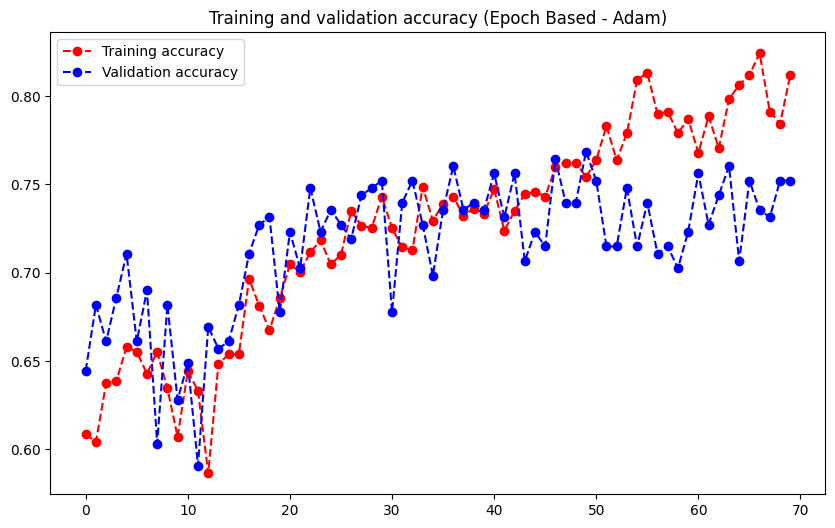

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation accuracy (Epoch Based - Adam)')
plt.legend(loc=0)

plt.show()

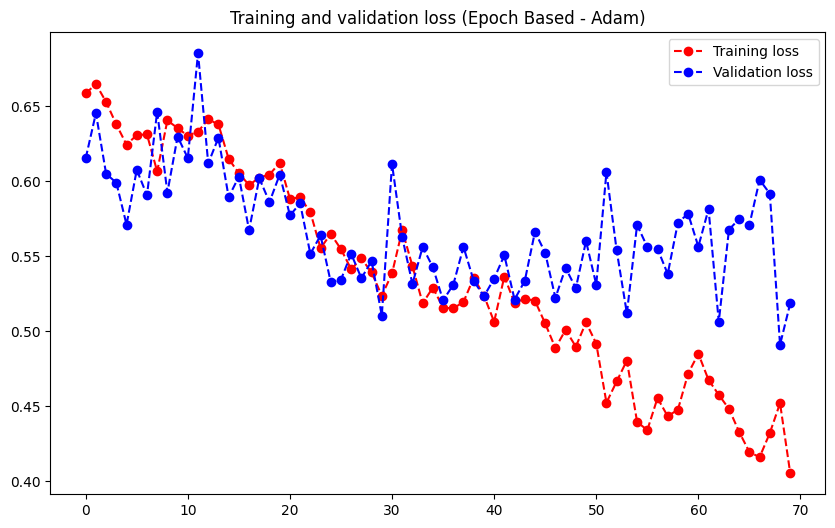

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_loss, 'b', label='Validation loss', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation loss (Epoch Based - Adam)')
plt.legend(loc=0)

plt.show()